# 1. Library Import

In [1]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 

import warnings
import datetime
import random
import tensorflow as tf
warnings.filterwarnings("ignore")

In [2]:
# random seed
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    set_random_seed(seed)
    
SEED = 42
set_seeds(SEED)

# 2. 데이터 불러오기

## 1) read_csv

In [3]:
data_path = os.getenv('HOME')+ '/Projects/daconTrader/dataset'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2) numpy arrary로 변환하기

In [7]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    print(feature_size, time_size, sample_size)
    print(sample_index)
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [97]:
print(train_x_df.shape)
print(train_x_df.iloc[:, 2:].shape[1])
print(train_x_df.sample_id.value_counts().index)
train_x_df.head()

(10159560, 12)
10
Int64Index([   0, 4919, 4913, 4912, 4915, 4914, 4909, 4908, 4911, 4910,
            ...
            2454, 2455, 2452, 2453, 2450, 2451, 2448, 2449, 2446, 7360],
           dtype='int64', length=7362)


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [9]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [10]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [11]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



In [14]:
train_x_df['sample_id'].nunique()

7362

## 3) 샘플 확인하기

In [16]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

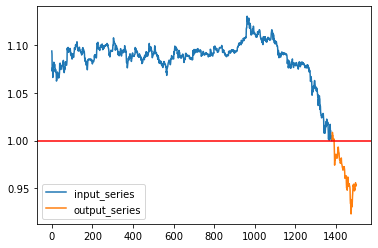

In [17]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1]) #종가
plt.show()

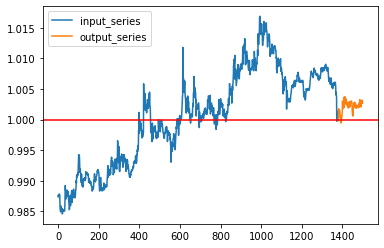

In [18]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1021
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1]) # 1-4, open, high, low, close
plt.show()

# 3. 모델 훈련하기

## 1) train 샘플 훈련하기 호가인하기

In [19]:
start_time = '2021-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')
start_dt

datetime.datetime(2021, 1, 31, 0, 0)

In [20]:
# start_time = '2021-01-31 00:00:00'
# start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [21]:
idx = 1004
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

In [22]:
import numpy as np 

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()
x_df.head()

,ds,y
0,2021-02-01,0.945916
1,2021-02-02,0.946467
2,2021-02-03,0.946880
3,2021-02-04,0.947774
4,2021-02-05,0.947912


In [28]:
# 파라미터 조정

# # prophet
# scale = 0.01
# width = 0.95
# point_range = 1
seasonality_prior_scale = 50.0

## neural prophet
epochs = 20
# batch_size = 64
learning_rate = 0.003


# AR net 
n_forecasts = 120 # 예측 기간의 크기  # future_periods랑 같아야한다. 
# num_hidden_layers = 64 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
trend_smoothness = 0.5
n_changepoints = 100   # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.05

# n_lags = 5  # >error : lambda delay가 없다 

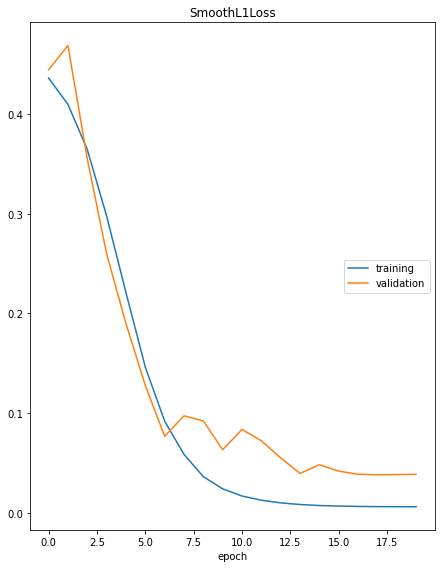

Epoch[20/20]: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s, SmoothL1Loss=0.00614, MAE=0.00732, RegLoss=0.00071, MAE_val=0.0199, SmoothL1Loss_val=0.0387]


In [49]:
nprophet = NeuralProphet(yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True,
                learning_rate=learning_rate,
                changepoints_range=changepoints_range, n_forecasts=n_forecasts,
                ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
                growth='logistic', seasonality_mode='additive', 
                trend_reg=trend_reg
            )


nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, valid_p=0.1)


nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [50]:
x_df.head()

,ds,y
0,2021-02-01,0.945916
1,2021-02-02,0.946467
2,2021-02-03,0.946880
3,2021-02-04,0.947774
4,2021-02-05,0.947912


In [51]:
# 120분 테스트 데이터를 예측합니다.
future_data = nprophet.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
forecast_data = nprophet.predict(future_data)
forecast_data[['ds', 'y', 'yhat1', 'trend']].tail(5)
forecast_data.head()

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
0,2021-02-01,0.945916,0.937137,-0.008779,0.956462,-0.005707,-0.013618
1,2021-02-02,0.946467,0.942380,-0.004086,0.956462,-0.000464,-0.013618
2,2021-02-03,0.946880,0.942376,-0.004504,0.956461,-0.000468,-0.013618
3,2021-02-04,0.947774,0.937069,-0.010705,0.956461,-0.005775,-0.013618
4,2021-02-05,0.947912,0.949209,0.001298,0.956460,0.006366,-0.013618


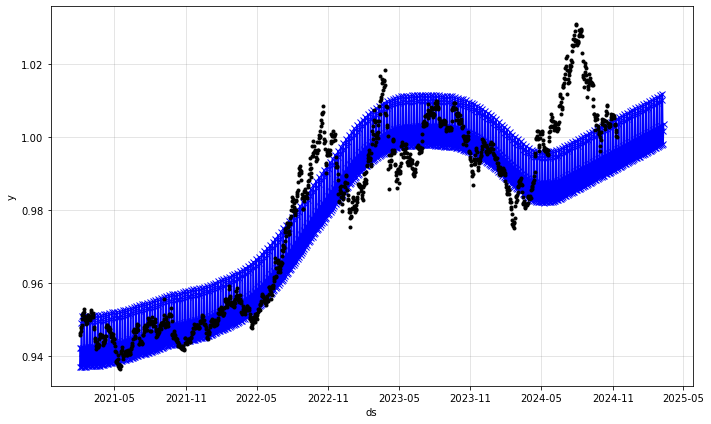

In [52]:
# 만들어진 데이터를 확인합니다.
fig1 = nprophet.plot(forecast_data)

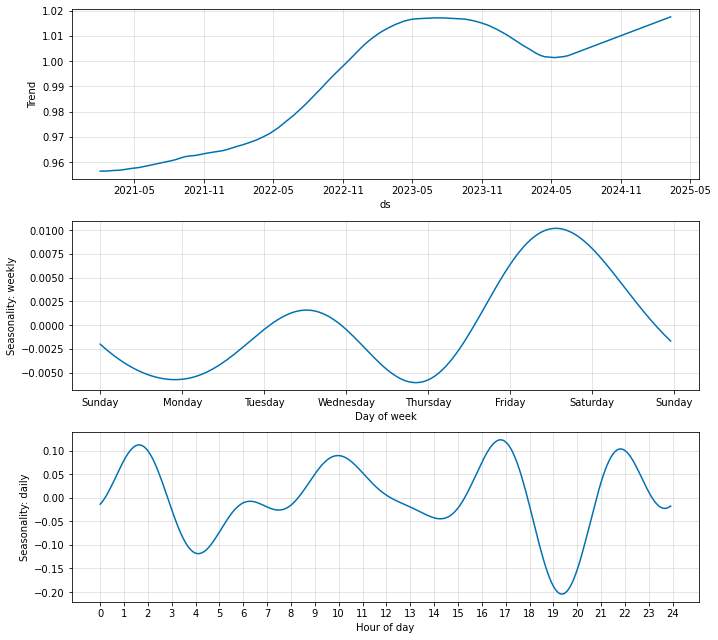

In [53]:
# 데이터의 추세를 확인합니다.
fig2 = nprophet.plot_components(forecast_data)

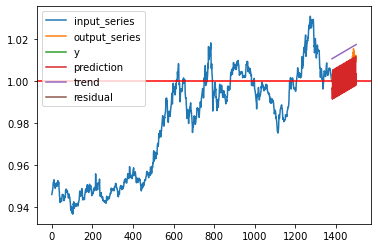

array([0.99665743, 0.9967106 , 0.99146086, 1.00365889, 1.0054121 ,
       0.99539077, 0.9917562 , 0.99705678, 0.99710989, 0.99186015,
       1.00405824, 1.00581145, 0.99579006, 0.99215549, 0.99745607,
       0.99750924, 0.99225944, 1.00445747, 1.0062108 , 0.99618936,
       0.99255478, 0.99785537, 0.99790853, 0.99265873, 1.00485682,
       1.00661004, 0.99658871, 0.99295408, 0.99825472, 0.99830782,
       0.99305809, 1.00525618, 1.00700939, 0.996988  , 0.99335343,
       0.99865401, 0.99870718, 0.99345738, 1.00565541, 1.00740874,
       0.99738729, 0.99375272, 0.9990533 , 0.99910647, 0.99385673,
       1.00605476, 1.00780797, 0.99778658, 0.99415201, 0.99945259,
       0.99950576, 0.99425602, 1.00645399, 1.00820732, 0.99818593,
       0.99455136, 0.99985194, 0.99990511, 0.99465531, 1.00685334,
       1.00860667, 0.99858522, 0.99495065, 1.00025129, 1.00030434,
       0.9950546 , 1.00725269, 1.0090059 , 0.99898452, 0.99534994,
       1.00065053, 1.00070369, 0.99545395, 1.00765204, 1.00940

In [54]:
y = forecast_data.y.values[-120:]
pred_y = forecast_data.yhat1.values[-120:]
trend = forecast_data.trend.values[-120:]
residual = forecast_data.residual1.values[-120:]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), y, label = 'y')
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), trend, label = 'trend')
plt.plot(np.arange(1380, 1380+120), residual, label = 'residual')
plt.legend()
plt.show()

pred_y

## 2) validation set 훈련하기
### <1> validation 데이터 생성하기

In [75]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

### <2> 학습 및 추론하기

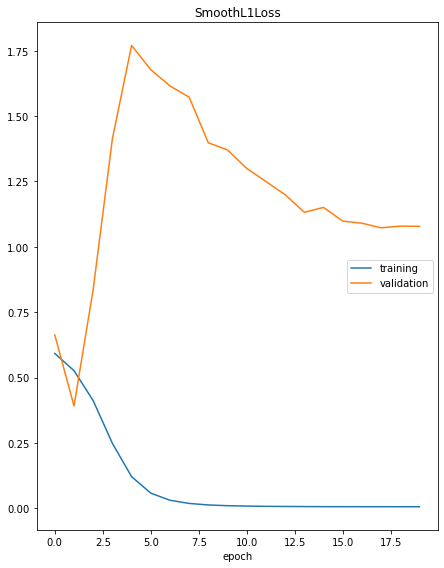


100%|██████████| 300/300 [12:26<00:00,  2.49s/it]


In [77]:
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        x_series = valid_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        nprophet = NeuralProphet(yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True,
                learning_rate=learning_rate,
                
                changepoints_range=changepoints_range, n_forecasts=n_forecasts,
                ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
                growth='logistic', seasonality_mode='additive', 
                trend_reg=trend_reg
            )


        nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, 
                            valid_p=0.1)


        nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
        # 120분 테스트 데이터를 예측합니다.
        future_data = nprophet.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
        forecast_data = nprophet.predict(future_data)

        pred_y = forecast_data.yhat1.values[-120:]
        trend = forecast_data.trend.values[-120:]
        residual = forecast_data.residual1.values[-120:]

        valid_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

In [78]:
print(len(valid_pred_array))
print(valid_pred_array.shape)

300
(300, 120)


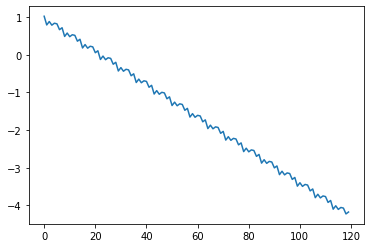

In [79]:
# plot_series(x_series[0], pred_y[0])
plt.plot(valid_pred_array[100])

### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [80]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    sell = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
        
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [81]:
def sell_10min(x_array):
    if np.argmax(x_array.all(), axis=1) < 30:
        return np.argmax(x_array)

In [86]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [89]:
valid_submission.buy_quantity.value_counts()

1    168
0    132
Name: buy_quantity, dtype: int64

In [96]:
valid_submission[valid_submission['buy_quantity']==1]['sell_time'].value_counts()

119    147
118      8
117      6
0        2
2        2
116      2
3        1
Name: sell_time, dtype: int64

### <4> 투자 후 금액 계산하기

In [91]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [92]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [93]:
# 투자 후 금액
print(total_momey)

7591.327131966754


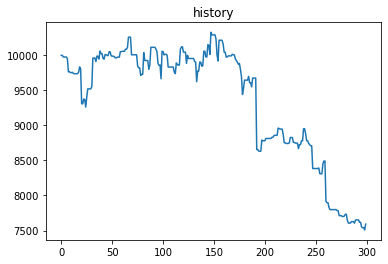

In [94]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# 4. test 데이터 학습하고 추론하기

In [95]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])

for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
    
        nprophet = NeuralProphet(yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True,
                learning_rate=learning_rate,
                changepoints_range=changepoints_range, n_forecasts=n_forecasts,
                ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
                growth='logistic', seasonality_mode='additive', 
                trend_reg=trend_reg
            )


        nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, 
                            valid_p=0.1)


        nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
        # 120분 테스트 데이터를 예측합니다.
        future_data = nprophet.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
        forecast_data = nprophet.predict(future_data)

        pred_y = forecast_data.yhat1.values[-120:]
        trend = forecast_data.trend.values[-120:]
        residual = forecast_data.residual1.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

  7%|▋         | 37/529 [00:00<00:01, 367.87it/s]

0  샘플은 수렴하지 않습니다.
1  샘플은 수렴하지 않습니다.
2  샘플은 수렴하지 않습니다.
3  샘플은 수렴하지 않습니다.
4  샘플은 수렴하지 않습니다.
5  샘플은 수렴하지 않습니다.
6  샘플은 수렴하지 않습니다.
7  샘플은 수렴하지 않습니다.
8  샘플은 수렴하지 않습니다.
9  샘플은 수렴하지 않습니다.
10  샘플은 수렴하지 않습니다.
11  샘플은 수렴하지 않습니다.
12  샘플은 수렴하지 않습니다.
13  샘플은 수렴하지 않습니다.
14  샘플은 수렴하지 않습니다.
15  샘플은 수렴하지 않습니다.
16  샘플은 수렴하지 않습니다.
17  샘플은 수렴하지 않습니다.
18  샘플은 수렴하지 않습니다.
19  샘플은 수렴하지 않습니다.
20  샘플은 수렴하지 않습니다.
21  샘플은 수렴하지 않습니다.
22  샘플은 수렴하지 않습니다.
23  샘플은 수렴하지 않습니다.
24  샘플은 수렴하지 않습니다.
25  샘플은 수렴하지 않습니다.
26  샘플은 수렴하지 않습니다.
27  샘플은 수렴하지 않습니다.
28  샘플은 수렴하지 않습니다.
29  샘플은 수렴하지 않습니다.
30  샘플은 수렴하지 않습니다.
31  샘플은 수렴하지 않습니다.
32  샘플은 수렴하지 않습니다.
33  샘플은 수렴하지 않습니다.
34  샘플은 수렴하지 않습니다.
35  샘플은 수렴하지 않습니다.
36  샘플은 수렴하지 않습니다.
37  샘플은 수렴하지 않습니다.
38  샘플은 수렴하지 않습니다.
39  샘플은 수렴하지 않습니다.
40  샘플은 수렴하지 않습니다.
41  샘플은 수렴하지 않습니다.
42  샘플은 수렴하지 않습니다.
43  샘플은 수렴하지 않습니다.
44  샘플은 수렴하지 않습니다.
45  샘플은 수렴하지 않습니다.
46  샘플은 수렴하지 않습니다.
47  샘플은 수렴하지 않습니다.
48  샘플은 수렴하지 않습니다.
49  샘플은 수렴하지 않습니다.
50  샘플은 수렴하지 않습니다.
51  샘플은 수렴하지 않습니다.
52  샘플은 수렴하지 않습니다.
53 

 21%|██        | 111/529 [00:00<00:01, 295.16it/s]

71  샘플은 수렴하지 않습니다.
72  샘플은 수렴하지 않습니다.
73  샘플은 수렴하지 않습니다.
74  샘플은 수렴하지 않습니다.
75  샘플은 수렴하지 않습니다.
76  샘플은 수렴하지 않습니다.
77  샘플은 수렴하지 않습니다.
78  샘플은 수렴하지 않습니다.
79  샘플은 수렴하지 않습니다.
80  샘플은 수렴하지 않습니다.
81  샘플은 수렴하지 않습니다.
82  샘플은 수렴하지 않습니다.
83  샘플은 수렴하지 않습니다.
84  샘플은 수렴하지 않습니다.
85  샘플은 수렴하지 않습니다.
86  샘플은 수렴하지 않습니다.
87  샘플은 수렴하지 않습니다.
88  샘플은 수렴하지 않습니다.
89  샘플은 수렴하지 않습니다.
90  샘플은 수렴하지 않습니다.
91  샘플은 수렴하지 않습니다.
92  샘플은 수렴하지 않습니다.
93  샘플은 수렴하지 않습니다.
94  샘플은 수렴하지 않습니다.
95  샘플은 수렴하지 않습니다.
96  샘플은 수렴하지 않습니다.
97  샘플은 수렴하지 않습니다.
98  샘플은 수렴하지 않습니다.
99  샘플은 수렴하지 않습니다.
100  샘플은 수렴하지 않습니다.
101  샘플은 수렴하지 않습니다.
102  샘플은 수렴하지 않습니다.
103  샘플은 수렴하지 않습니다.
104  샘플은 수렴하지 않습니다.
105  샘플은 수렴하지 않습니다.
106  샘플은 수렴하지 않습니다.
107  샘플은 수렴하지 않습니다.
108  샘플은 수렴하지 않습니다.
109  샘플은 수렴하지 않습니다.
110  샘플은 수렴하지 않습니다.
111  샘플은 수렴하지 않습니다.
112  샘플은 수렴하지 않습니다.
113  샘플은 수렴하지 않습니다.
114  샘플은 수렴하지 않습니다.
115  샘플은 수렴하지 않습니다.
116  샘플은 수렴하지 않습니다.
117  샘플은 수렴하지 않습니다.
118  샘플은 수렴하지 않습니다.
119  샘플은 수렴하지 않습니다.
120  샘플은 수렴하지 않습니다.
121  샘플은 수렴하지 않습니다.
122  샘플은 

 38%|███▊      | 199/529 [00:00<00:00, 372.59it/s]

154  샘플은 수렴하지 않습니다.
155  샘플은 수렴하지 않습니다.
156  샘플은 수렴하지 않습니다.
157  샘플은 수렴하지 않습니다.
158  샘플은 수렴하지 않습니다.
159  샘플은 수렴하지 않습니다.
160  샘플은 수렴하지 않습니다.
161  샘플은 수렴하지 않습니다.
162  샘플은 수렴하지 않습니다.
163  샘플은 수렴하지 않습니다.
164  샘플은 수렴하지 않습니다.
165  샘플은 수렴하지 않습니다.
166  샘플은 수렴하지 않습니다.
167  샘플은 수렴하지 않습니다.
168  샘플은 수렴하지 않습니다.
169  샘플은 수렴하지 않습니다.
170  샘플은 수렴하지 않습니다.
171  샘플은 수렴하지 않습니다.
172  샘플은 수렴하지 않습니다.
173  샘플은 수렴하지 않습니다.
174  샘플은 수렴하지 않습니다.
175  샘플은 수렴하지 않습니다.
176  샘플은 수렴하지 않습니다.
177  샘플은 수렴하지 않습니다.
178  샘플은 수렴하지 않습니다.
179  샘플은 수렴하지 않습니다.
180  샘플은 수렴하지 않습니다.
181  샘플은 수렴하지 않습니다.
182  샘플은 수렴하지 않습니다.
183  샘플은 수렴하지 않습니다.
184  샘플은 수렴하지 않습니다.
185  샘플은 수렴하지 않습니다.
186  샘플은 수렴하지 않습니다.
187  샘플은 수렴하지 않습니다.
188  샘플은 수렴하지 않습니다.
189  샘플은 수렴하지 않습니다.
190  샘플은 수렴하지 않습니다.
191  샘플은 수렴하지 않습니다.
192  샘플은 수렴하지 않습니다.
193  샘플은 수렴하지 않습니다.
194  샘플은 수렴하지 않습니다.
195  샘플은 수렴하지 않습니다.
196  샘플은 수렴하지 않습니다.
197  샘플은 수렴하지 않습니다.
198  샘플은 수렴하지 않습니다.
199  샘플은 수렴하지 않습니다.
200  샘플은 수렴하지 않습니다.
201  샘플은 수렴하지 않습니다.
202  샘플은 수렴하지 않습니다.
203  샘플은 수렴하지 않습니다.


 55%|█████▍    | 290/529 [00:00<00:00, 412.98it/s]

244  샘플은 수렴하지 않습니다.
245  샘플은 수렴하지 않습니다.
246  샘플은 수렴하지 않습니다.
247  샘플은 수렴하지 않습니다.
248  샘플은 수렴하지 않습니다.
249  샘플은 수렴하지 않습니다.
250  샘플은 수렴하지 않습니다.
251  샘플은 수렴하지 않습니다.
252  샘플은 수렴하지 않습니다.
253  샘플은 수렴하지 않습니다.
254  샘플은 수렴하지 않습니다.
255  샘플은 수렴하지 않습니다.
256  샘플은 수렴하지 않습니다.
257  샘플은 수렴하지 않습니다.
258  샘플은 수렴하지 않습니다.
259  샘플은 수렴하지 않습니다.
260  샘플은 수렴하지 않습니다.
261  샘플은 수렴하지 않습니다.
262  샘플은 수렴하지 않습니다.
263  샘플은 수렴하지 않습니다.
264  샘플은 수렴하지 않습니다.
265  샘플은 수렴하지 않습니다.
266  샘플은 수렴하지 않습니다.
267  샘플은 수렴하지 않습니다.
268  샘플은 수렴하지 않습니다.
269  샘플은 수렴하지 않습니다.
270  샘플은 수렴하지 않습니다.
271  샘플은 수렴하지 않습니다.
272  샘플은 수렴하지 않습니다.
273  샘플은 수렴하지 않습니다.
274  샘플은 수렴하지 않습니다.
275  샘플은 수렴하지 않습니다.
276  샘플은 수렴하지 않습니다.
277  샘플은 수렴하지 않습니다.
278  샘플은 수렴하지 않습니다.
279  샘플은 수렴하지 않습니다.
280  샘플은 수렴하지 않습니다.
281  샘플은 수렴하지 않습니다.
282  샘플은 수렴하지 않습니다.
283  샘플은 수렴하지 않습니다.
284  샘플은 수렴하지 않습니다.
285  샘플은 수렴하지 않습니다.
286  샘플은 수렴하지 않습니다.
287  샘플은 수렴하지 않습니다.
288  샘플은 수렴하지 않습니다.
289  샘플은 수렴하지 않습니다.
290  샘플은 수렴하지 않습니다.
291  샘플은 수렴하지 않습니다.
292  샘플은 수렴하지 않습니다.
293  샘플은 수렴하지 않습니다.


 72%|███████▏  | 382/529 [00:00<00:00, 434.13it/s]

335  샘플은 수렴하지 않습니다.
336  샘플은 수렴하지 않습니다.
337  샘플은 수렴하지 않습니다.
338  샘플은 수렴하지 않습니다.
339  샘플은 수렴하지 않습니다.
340  샘플은 수렴하지 않습니다.
341  샘플은 수렴하지 않습니다.
342  샘플은 수렴하지 않습니다.
343  샘플은 수렴하지 않습니다.
344  샘플은 수렴하지 않습니다.
345  샘플은 수렴하지 않습니다.
346  샘플은 수렴하지 않습니다.
347  샘플은 수렴하지 않습니다.
348  샘플은 수렴하지 않습니다.
349  샘플은 수렴하지 않습니다.
350  샘플은 수렴하지 않습니다.
351  샘플은 수렴하지 않습니다.
352  샘플은 수렴하지 않습니다.
353  샘플은 수렴하지 않습니다.
354  샘플은 수렴하지 않습니다.
355  샘플은 수렴하지 않습니다.
356  샘플은 수렴하지 않습니다.
357  샘플은 수렴하지 않습니다.
358  샘플은 수렴하지 않습니다.
359  샘플은 수렴하지 않습니다.
360  샘플은 수렴하지 않습니다.
361  샘플은 수렴하지 않습니다.
362  샘플은 수렴하지 않습니다.
363  샘플은 수렴하지 않습니다.
364  샘플은 수렴하지 않습니다.
365  샘플은 수렴하지 않습니다.
366  샘플은 수렴하지 않습니다.
367  샘플은 수렴하지 않습니다.
368  샘플은 수렴하지 않습니다.
369  샘플은 수렴하지 않습니다.
370  샘플은 수렴하지 않습니다.
371  샘플은 수렴하지 않습니다.
372  샘플은 수렴하지 않습니다.
373  샘플은 수렴하지 않습니다.
374  샘플은 수렴하지 않습니다.
375  샘플은 수렴하지 않습니다.
376  샘플은 수렴하지 않습니다.
377  샘플은 수렴하지 않습니다.
378  샘플은 수렴하지 않습니다.
379  샘플은 수렴하지 않습니다.
380  샘플은 수렴하지 않습니다.
381  샘플은 수렴하지 않습니다.
382  샘플은 수렴하지 않습니다.
383  샘플은 수렴하지 않습니다.
384  샘플은 수렴하지 않습니다.


 89%|████████▉ | 472/529 [00:01<00:00, 435.40it/s]

422  샘플은 수렴하지 않습니다.
423  샘플은 수렴하지 않습니다.
424  샘플은 수렴하지 않습니다.
425  샘플은 수렴하지 않습니다.
426  샘플은 수렴하지 않습니다.
427  샘플은 수렴하지 않습니다.
428  샘플은 수렴하지 않습니다.
429  샘플은 수렴하지 않습니다.
430  샘플은 수렴하지 않습니다.
431  샘플은 수렴하지 않습니다.
432  샘플은 수렴하지 않습니다.
433  샘플은 수렴하지 않습니다.
434  샘플은 수렴하지 않습니다.
435  샘플은 수렴하지 않습니다.
436  샘플은 수렴하지 않습니다.
437  샘플은 수렴하지 않습니다.
438  샘플은 수렴하지 않습니다.
439  샘플은 수렴하지 않습니다.
440  샘플은 수렴하지 않습니다.
441  샘플은 수렴하지 않습니다.
442  샘플은 수렴하지 않습니다.
443  샘플은 수렴하지 않습니다.
444  샘플은 수렴하지 않습니다.
445  샘플은 수렴하지 않습니다.
446  샘플은 수렴하지 않습니다.
447  샘플은 수렴하지 않습니다.
448  샘플은 수렴하지 않습니다.
449  샘플은 수렴하지 않습니다.
450  샘플은 수렴하지 않습니다.
451  샘플은 수렴하지 않습니다.
452  샘플은 수렴하지 않습니다.
453  샘플은 수렴하지 않습니다.
454  샘플은 수렴하지 않습니다.
455  샘플은 수렴하지 않습니다.
456  샘플은 수렴하지 않습니다.
457  샘플은 수렴하지 않습니다.
458  샘플은 수렴하지 않습니다.
459  샘플은 수렴하지 않습니다.
460  샘플은 수렴하지 않습니다.
461  샘플은 수렴하지 않습니다.
462  샘플은 수렴하지 않습니다.
463  샘플은 수렴하지 않습니다.
464  샘플은 수렴하지 않습니다.
465  샘플은 수렴하지 않습니다.
466  샘플은 수렴하지 않습니다.
467  샘플은 수렴하지 않습니다.
468  샘플은 수렴하지 않습니다.
469  샘플은 수렴하지 않습니다.
470  샘플은 수렴하지 않습니다.
471  샘플은 수렴하지 않습니다.


100%|██████████| 529/529 [00:01<00:00, 399.52it/s]

513  샘플은 수렴하지 않습니다.
514  샘플은 수렴하지 않습니다.
515  샘플은 수렴하지 않습니다.
516  샘플은 수렴하지 않습니다.
517  샘플은 수렴하지 않습니다.
518  샘플은 수렴하지 않습니다.
519  샘플은 수렴하지 않습니다.
520  샘플은 수렴하지 않습니다.
521  샘플은 수렴하지 않습니다.
522  샘플은 수렴하지 않습니다.
523  샘플은 수렴하지 않습니다.
524  샘플은 수렴하지 않습니다.
525  샘플은 수렴하지 않습니다.
526  샘플은 수렴하지 않습니다.
527  샘플은 수렴하지 않습니다.
528  샘플은 수렴하지 않습니다.


In [64]:
x_df

,ds,y
0,2021-02-01,0.994208
1,2021-02-02,0.994584
2,2021-02-03,0.992628
3,2021-02-04,0.996615
4,2021-02-05,0.994734
...,...,...
1375,2024-11-07,1.001805
1376,2024-11-08,0.998571
1377,2024-11-09,0.999323
1378,2024-11-10,1.000903


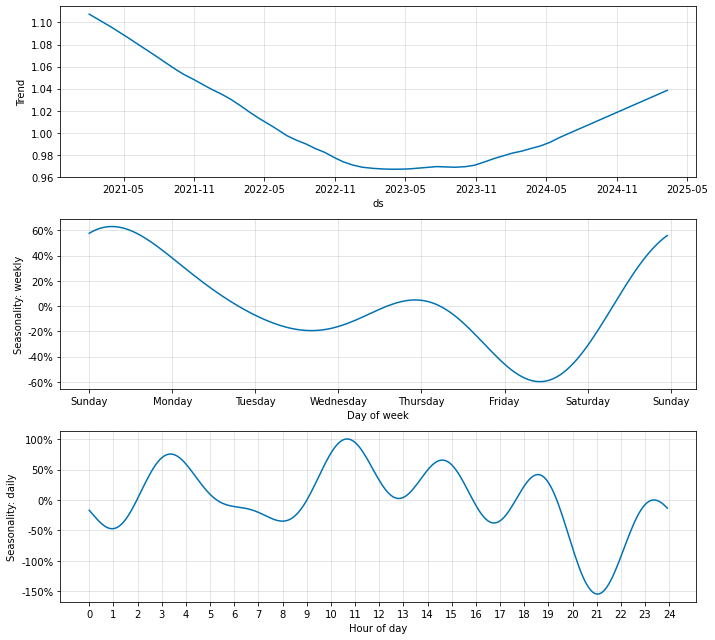

In [65]:
fig_comp = nprophet.plot_components(forecast_data)

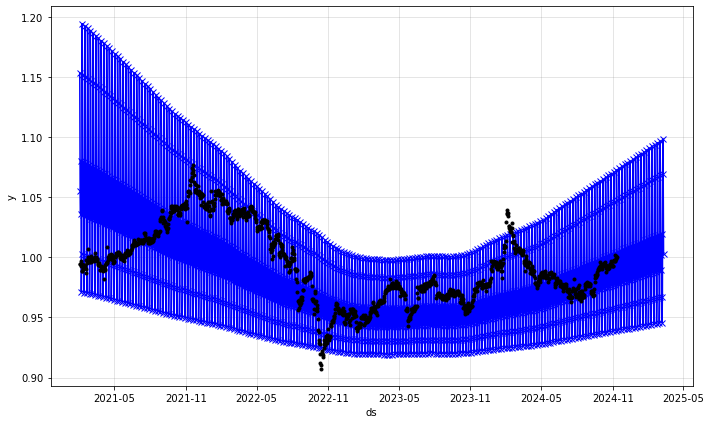

In [66]:
from fbprophet.plot import add_changepoints_to_plot

fig = nprophet.plot(forecast_data)

## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [67]:
test_pred_array.shape

(529, 120)

In [68]:
submission = array_to_submission(test_x_array, test_pred_array)

In [69]:
import time

submission.to_csv(data_path+"/nproh_{}.csv".format(time.strftime('%H%M%S')), index = False)

In [70]:
# submission.to_csv(data_path+"/proh_scale={}_width={}_range={}_{}.csv".format(scale, width, point_range, time.strftime('%H%M%S')), index = False)

In [71]:
submission[submission['sell_time']!=0]['sell_time']

0      116
1        3
2      113
3      113
4        2
      ... 
524    114
525    117
526    117
527    114
528    117
Name: sell_time, Length: 504, dtype: int64

In [72]:
submission.buy_quantity.value_counts()

0    375
1    154
Name: buy_quantity, dtype: int64

In [ ]:
submission[submission['buy_quantity']==1]['sell_time'].value_counts()